<a href="https://colab.research.google.com/github/nudojacopo/thesis/blob/main/HWK_labs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notes for Jacopo:


 <br>


Define the module path + import packages

In [ ]:
kernel=input('Choose a kernel to use...are you running in local? Y/N')

Choose a kernel to use...are you running in local? Y/Nn


In [ ]:
if kernel!='Y':
  !git clone https://github.com/nudojacopo/thesis.git
  from google.colab import drive
  drive.mount('/content/drive')
  source_data='/content/drive/MyDrive/thesis/data/voat/voat_labeled_data_unified.parquet'
  root='/content/'
else:
  source_data='/Users/jacoponudo/Documents/thesis/data/voat/voat_labeled_data_unified.parquet'
  root='/Users/jacoponudo/Documents/'
output=root+'src/HWK/output'
output_threads=root+'src/HWK/output/temporary'
import sys
module_path = root+'thesis/src/HWK'
sys.path.append(module_path)
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from HWK_package.functions import *
from scipy import stats
import random
from scipy.stats import chi2
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

Cloning into 'thesis'...
remote: Enumerating objects: 327, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 327 (delta 1), reused 0 (delta 0), pack-reused 320
Receiving objects: 100% (327/327), 25.87 MiB | 7.10 MiB/s, done.
Resolving deltas: 100% (131/131), done.
Mounted at /content/drive


# Fitting the model to data

Set source

In [ ]:
dataset = pd.read_parquet(source_data)
dataset['is_toxic']=dataset['toxicity_score']>0.6
user_toxic_activity=dataset.groupby(['root_submission','user'])['is_toxic'].sum().reset_index()
user_toxic_activity[user_toxic_activity['is_toxic']>10]

In [ ]:
dataset_user=dataset[dataset.user=='Mumbleberry'].copy()
dataset_user.sort_values(by='created_at', inplace=True)
dataset_user.root_submission.value_counts()
dataset_user=dataset_user[dataset_user.root_submission=='3348062'].copy()

Q1: Could we use a hawkes process to model the inter arrival time of comments?

Preparo i dati e fitto il modello

In [ ]:
observed_data = np.array([np.datetime64(x.replace(tzinfo=None)).astype(np.int64) for x in dataset_user['created_at']])
mean_lag=np.mean(np.diff(observed_data))
ℋ_t=observed_data-min(observed_data)+mean_lag
ℋ_t=ℋ_t/max(ℋ_t)
𝛉_exp=𝛉_exp_simple=exp_mle(ℋ_t,max(ℋ_t)+mean_lag)

Faccio il QQplot del modello

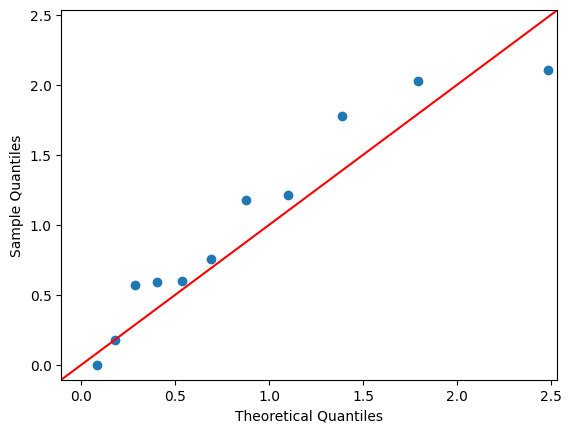

In [ ]:
tsShifted = exp_hawkes_compensators(ℋ_t, 𝛉_exp)
iat = np.diff(np.insert(tsShifted, 0, 0))
qqplot(iat, dist=stats.expon, fit=True, line="45")
plt.show()

Estraggo una metric per valutare il modello

In [ ]:
slope, intercept = sm.OLS(iat, sm.add_constant(stats.expon.ppf((np.arange(1, len(iat) + 1) - 0.5) / len(iat)))).fit().params
print("Pendenza della linea di riferimento adattata:", slope)
slope, intercept = 1, 0
predicted_values = slope * np.arange(1, len(iat) + 1) + intercept

Pendenza della linea di riferimento adattata: 0.051475550251306096


Calcolo delle distanze

In [ ]:
distances = np.abs(iat - predicted_values)

In [ ]:
print('errore modello semplice',distances.mean())

errore modello semplice 5.93331368201552


Q2: Is the fitting of the model improving using a flexibility of alpha (infetivity rate) sensible to comment's toxicity?

In [ ]:
# Preparo i dati e fitto il modello
observed_data = np.array([np.datetime64(x.replace(tzinfo=None)).astype(np.int64) for x in dataset_user['created_at']])
mean_lag=np.mean(np.diff(observed_data))
ℋ_t=observed_data-min(observed_data)+mean_lag
𝒯_T=list(dataset_user.toxicity_score)
𝛉_exp=𝛉_exp_toxicity=exp_mle_toxicity(ℋ_t,𝒯_T,max(ℋ_t))

Faccio il QQplot del modello

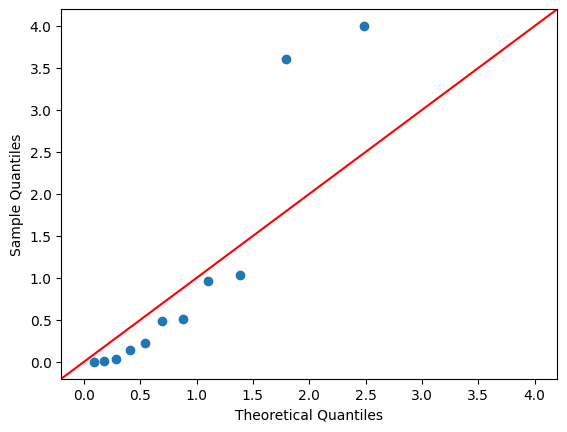

In [ ]:
tsShifted = exp_hawkes_compensators_toxicity(ℋ_t,𝒯_T, 𝛉_exp)
iat = np.diff(np.insert(tsShifted, 0, 0))
qqplot(iat, dist=stats.expon, fit=True, line="45")
plt.show()

Estraggo una metric per valutare il modello

In [ ]:
slope, intercept = sm.OLS(iat, sm.add_constant(stats.expon.ppf((np.arange(1, len(iat) + 1) - 0.5) / len(iat)))).fit().params
print("Pendenza della linea di riferimento adattata:", slope)

Pendenza della linea di riferimento adattata: 1.384439183937668


In [ ]:
slope, intercept = 1, 0
predicted_values = slope * np.arange(1, len(iat) + 1) + intercept

Calcolo delle distanze

In [ ]:
distances = np.abs(iat - predicted_values)

In [ ]:
print('errore modello tossicità',distances.mean())

errore modello tossicità 4.9998597136193155


Q3 Posso stimare i parametri di ciascun utente studiandone la verosimiglianza congiunta su tutti i threads?<br>
--------------------------- Using α ---------------------------------------------------

In [ ]:
data_user = filter_dataset(dataset, 'Mumbleberry', min_comments=3, sample=False)
ℋ_T_list, magnitude_list,time_list = prepare_data(data_user, dataset)
θ_exp_mle_T = exponential_mle(ℋ_T_list, time_list)

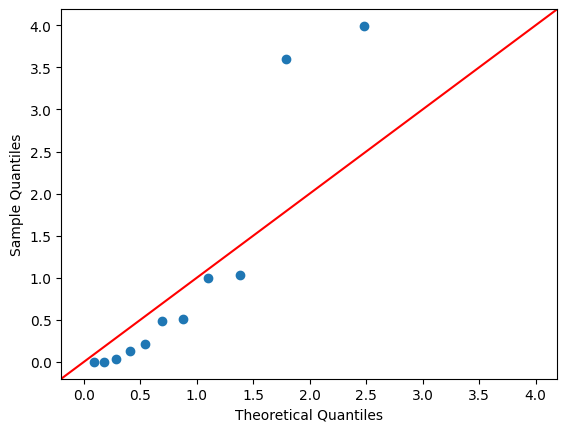

In [ ]:
tsShifted = exp_hawkes_compensators(ℋ_t, θ_exp_mle_T)
iat = np.diff(np.insert(tsShifted, 0, 0))
qqplot(iat, dist=stats.expon, fit=True, line="45")
plt.show()

In [ ]:
slope, intercept = sm.OLS(iat, sm.add_constant(stats.expon.ppf((np.arange(1, len(iat) + 1) - 0.5) / len(iat)))).fit().params
print("Pendenza della linea di riferimento adattata:", slope)

Pendenza della linea di riferimento adattata: 0.037238471722014464


In [ ]:
slope, intercept = 1, 0
predicted_values = slope * np.arange(1, len(iat) + 1) + intercept

In [ ]:
distances = np.abs(iat - predicted_values)
print('errore modello tossicità',distances.mean())

errore modello tossicità 5.973319434241515


--------------------------- Using 2α ---------------------------------------------------

In [ ]:
data_user = filter_dataset(dataset, 'Mumbleberry', min_comments=3, sample=False)
ℋ_T_list, magnitude_list,time_list = prepare_data(data_user, dataset)
θ_exp_mle_T = exponential_mle_toxicity(ℋ_T_list, magnitude_list, time_list)

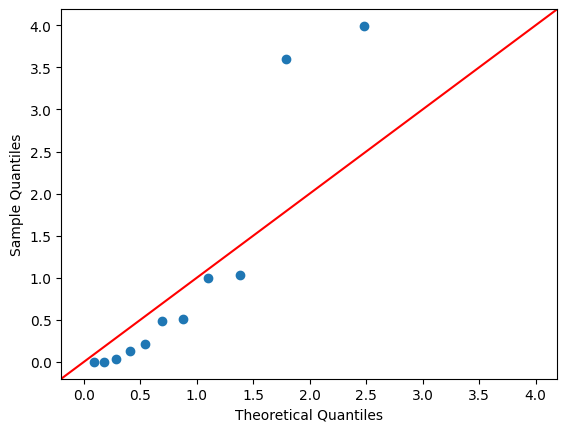

In [ ]:
tsShifted = exp_hawkes_compensators_toxicity(ℋ_t,𝒯_T, θ_exp_mle_T)
iat = np.diff(np.insert(tsShifted, 0, 0))
qqplot(iat, dist=stats.expon, fit=True, line="45")
plt.show()

In [ ]:
slope, intercept = sm.OLS(iat, sm.add_constant(stats.expon.ppf((np.arange(1, len(iat) + 1) - 0.5) / len(iat)))).fit().params
print("Pendenza della linea di riferimento adattata:", slope)

Pendenza della linea di riferimento adattata: 0.037238471722014464


In [ ]:
slope, intercept = 1, 0
predicted_values = slope * np.arange(1, len(iat) + 1) + intercept

In [ ]:
distances = np.abs(iat - predicted_values)
print('errore modello tossicità',distances.mean())

errore modello tossicità 5.973319434241515


# Study the parameters of an Hawkes process

In [ ]:
dataset = pd.read_parquet(source_data)
dataset['is_toxic']=dataset['toxicity_score']>0.6
user_toxic_activity=dataset.groupby(['root_submission','user'])['is_toxic'].sum().reset_index()
user_toxic_activity[user_toxic_activity['is_toxic']>10]

dataset_user=dataset[dataset.user=='Mumbleberry'].copy()
dataset_user.sort_values(by='created_at', inplace=True)
dataset_user.root_submission.value_counts()
dataset_user=dataset_user[dataset_user.root_submission=='3348062'].copy()

In [ ]:
# Preparo i dati e fitto il modello
observed_data = np.array([np.datetime64(x.replace(tzinfo=None)).astype(np.int64) for x in dataset_user['created_at']])
start_conversation=np.datetime64(min(dataset[dataset['root_submission']=='3348062']['created_at']).replace(tzinfo=None))
end_conversation=np.datetime64(max(dataset[dataset['root_submission']=='3348062']['created_at']).replace(tzinfo=None))

ℋ_t = (observed_data - start_conversation.astype(np.int64)) / (end_conversation.astype(np.int64) - start_conversation.astype(np.int64))
𝒯_T=list(dataset_user.toxicity_score)
𝛉_exp=exp_mle(ℋ_t,1)

In [ ]:
len(ℋ_t)

11

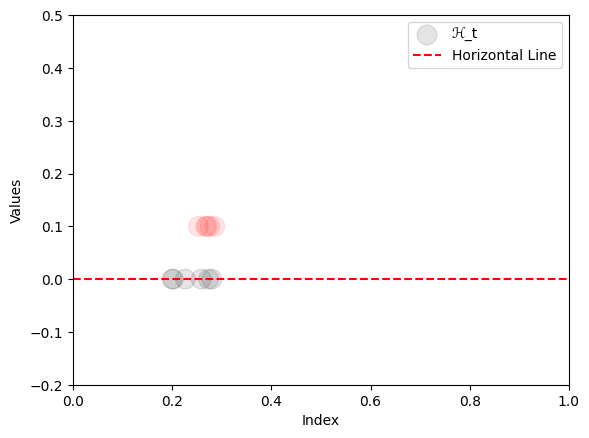

In [ ]:
x = [0]*len(ℋ_t)
colors = ['r' if score > 0.5 else 'black' for score in 𝒯_T]
x = [.1 if score > 0.5 else 0 for score in 𝒯_T]
# Plot the scatter plot with colors
plt.scatter(ℋ_t, x, c=colors, label='ℋ_t', alpha=0.1,s=200)

# Plot the horizontal line
plt.axhline(0, color='r', linestyle='--', label='Horizontal Line')

# Add labels and legend
plt.xlabel('Index')
plt.ylabel('Values')
plt.xlim(0,1)
plt.ylim(-0.2,.5)
plt.legend()

# Show plot
plt.show()

In [ ]:
simulazioni_su_thread = []
𝛉_exp=np.array([ 3, 42, 60])
for i in (range(10000)):
    simulazione_su_thread = exp_simulate_by_composition_alt(𝛉_exp, 1)
    simulazioni_su_thread.append(len(simulazione_su_thread))
print( np.mean(simulazioni_su_thread))

simulazioni_su_thread = []
𝛉_exp=np.array([ 11, 1.5, 60])
for i in (range(10000)):
    simulazione_su_thread = exp_simulate_by_composition_alt(𝛉_exp, 1)
    simulazioni_su_thread.append(len(simulazione_su_thread))
print( np.mean(simulazioni_su_thread))



11.1072
11.3069


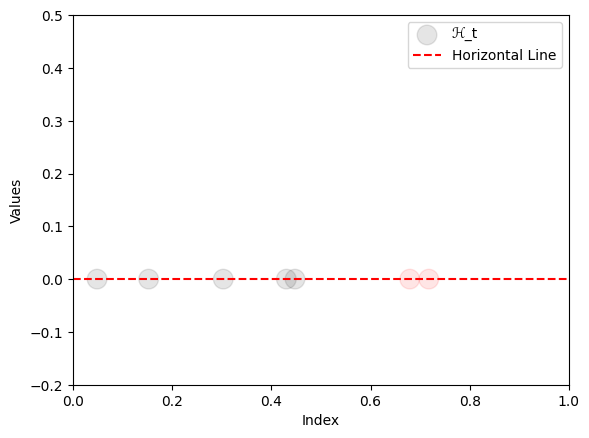

In [ ]:
ℋ_t=simulazione_su_thread
x = [0]*len(ℋ_t)
colors = ['r' if score > 0.5 else 'black' for score in ℋ_t]
# Plot the scatter plot with colors
plt.scatter(ℋ_t, x, c=colors, label='ℋ_t', alpha=0.1,s=200)

# Plot the horizontal line
plt.axhline(0, color='r', linestyle='--', label='Horizontal Line')

# Add labels and legend
plt.xlabel('Index')
plt.ylabel('Values')
plt.xlim(0,1)
plt.ylim(-0.2,.5)
plt.legend()

# Show plot
plt.show()

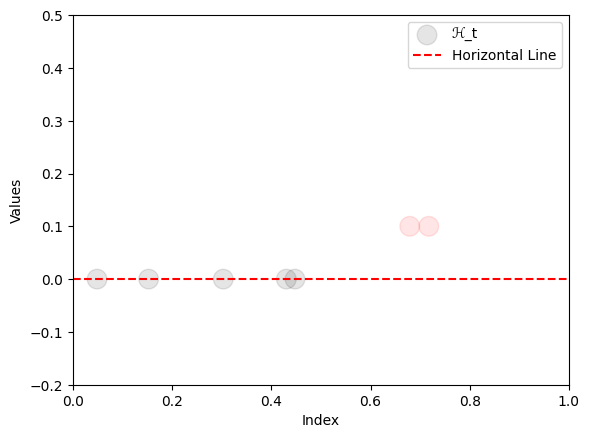

In [ ]:
ℋ_t=simulazione_su_thread
x = [0]*len(ℋ_t)
colors = ['r' if score > 0.5 else 'black' for score in ℋ_t]
x = [.1 if score > 0.5 else 0 for score in ℋ_t]
# Plot the scatter plot with colors
plt.scatter(ℋ_t, x, c=colors, label='ℋ_t', alpha=0.1,s=200)

# Plot the horizontal line
plt.axhline(0, color='r', linestyle='--', label='Horizontal Line')

# Add labels and legend
plt.xlabel('Index')
plt.ylabel('Values')
plt.xlim(0,1)
plt.ylim(-0.2,.5)
plt.legend()

# Show plot
plt.show()

In [ ]:
import numpy as np
import pandas as pd

# Lista dei parametri
lambda_grid =  np.concatenate(([0.5], np.arange(1, 600,3 )))
alpha_grid  =  np.concatenate(([0.0001],np.arange(1, 10,1), np.arange(10, 20,10)))
beta_grid   =    np.arange(60, 300,20)

# Definizione della funzione da ottimizzare
def function_to_optimize(l, alpha,beta):
    𝛉 = np.array([l,alpha,beta ])
    simulazioni_su_thread = []
    for i in (range(1000)):
        simulazione_su_thread = exp_simulate_by_composition_alt(𝛉, 1)
        simulazioni_su_thread.append(len(simulazione_su_thread))
    return np.mean(simulazioni_su_thread),np.std(simulazioni_su_thread),simulazioni_su_thread


# Lista per memorizzare i risultati
results = []

# Esecuzione della grid search
for l in tqdm(lambda_grid):
    for alpha in alpha_grid:
      for beta in beta_grid:
        sd_expected_value=function_to_optimize(l, alpha,beta)[1]
        mu_expected_value = (function_to_optimize(l, alpha,beta)[0])
        results.append({'lambda': l, 'alpha': alpha,'beta':beta, 'mu_expected_value': mu_expected_value,'sd_exepected_value':sd_expected_value})
# Creazione del DataFrame
df = pd.DataFrame(results)

# Salvataggio del DataFrame su file CSV
df.to_csv('/content/drive/MyDrive/thesis/data/grid_search_results_2.csv', index=False)

# Stampare il DataFrame
print(df)

,lambda,alpha,beta,mu_expected_value,sd_exepected_value
0,0.5,0.0001,60,0.485,0.675851
1,0.5,0.0001,80,0.491,0.718130
2,0.5,0.0001,100,0.480,0.706987
3,0.5,0.0001,120,0.519,0.712738
4,0.5,0.0001,140,0.479,0.733264
...,...,...,...,...,...
19245,433.0,8.0000,240,448.260,21.510975
19246,433.0,8.0000,260,447.459,22.100396
19247,433.0,8.0000,280,445.902,22.216044
19248,433.0,9.0000,60,506.845,26.853795


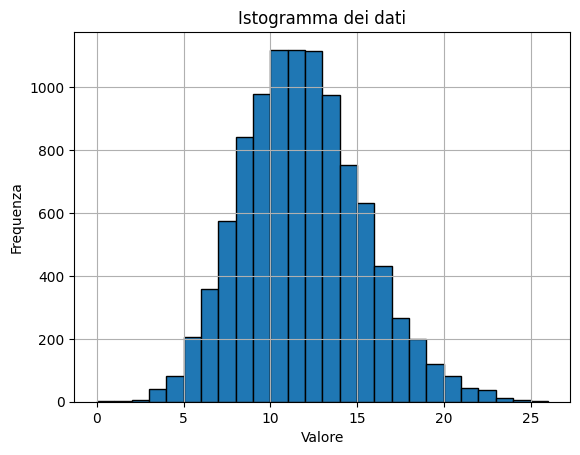

In [ ]:
oss=simulazioni_su_thread
plt.hist(oss, bins=range(min(oss), max(oss) + 1), edgecolor='black')  # Definiamo i bin dai valori minimi a massimi dei dati
plt.xlabel('Valore')
plt.ylabel('Frequenza')
plt.title('Istogramma dei dati')
plt.grid(True)
plt.show()

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/thesis/data/grid_search_results.csv')
df['lower_bound']=df['mu_expected_value']-2*df['sd_exepected_value']
df['upper_bound']=df['mu_expected_value']+2*df['sd_exepected_value']
df['IC_size']=df['upper_bound']-df['lower_bound']

In [ ]:
# Creazione del tracciato
import plotly.graph_objs as go
trace = go.Scatter3d(
    x=data['lambda'],
    y=data['alpha'],
    z=data['beta'],
    mode='markers',
    marker=dict(
        size=10,
        color='rgb(255,0,0)',  # Impostiamo tutti i punti dello stesso colore
        opacity=0.8
    )
)

# Layout
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='Lambda'),
        yaxis=dict(title='Alpha'),
        zaxis=dict(title='Beta')
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

# Creazione della figura
fig = go.Figure(data=[trace], layout=layout)

# Plot
fig.show()

In [ ]:
data[data['lambda']==6]

,lambda,alpha,beta,errore,sd_errore,lower_bound,upper_bound,IC_size
108240,6.0,22.5,60.0,-0.988,4.992839,-10.973678,8.997678,19.971355
108241,6.0,22.5,60.5,-0.956,5.262202,-11.480405,9.568405,21.048810
108321,6.0,23.0,60.5,-0.888,5.065361,-11.018721,9.242721,20.261443
108400,6.0,23.5,60.0,-0.798,5.285939,-11.369878,9.773878,21.143756
108401,6.0,23.5,60.5,-0.542,5.196814,-10.935629,9.851629,20.787257
...,...,...,...,...,...,...,...,...
112155,6.0,46.5,97.5,0.743,6.658228,-12.573455,14.059455,26.632911
112156,6.0,46.5,98.0,0.779,6.561987,-12.344974,13.902974,26.247947
112157,6.0,46.5,98.5,0.295,6.369142,-12.443285,13.033285,25.476570
112158,6.0,46.5,99.0,0.495,6.307248,-12.119496,13.109496,25.228991


In [ ]:
data=pd.read_csv('/content/drive/MyDrive/thesis/data/grid_search_results.csv')
alphas = data["alpha"].unique()
lambdas = data["lambda"].unique()
heatmap_grid = [[0 for _ in lambdas] for _ in alphas]

for index, row in data.iterrows():
    alpha_idx = np.where(alphas == row["alpha"])[0][0]
    lambda_idx = np.where(lambdas == row["lambda"])[0][0]
    heatmap_grid[alpha_idx][lambda_idx] = row["errore"]


KeyError: 'errore'

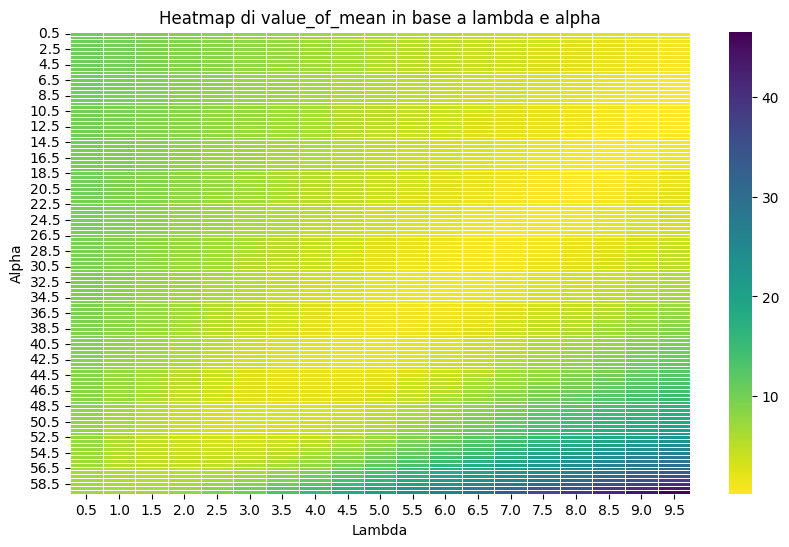

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Supponiamo che il tuo DataFrame sia già stato creato come 'df'

# Creazione del heatmap
df['errore']=df['errore'].abs()
df=df.groupby(['lambda','alpha'])['mu_expected_value'].mean().reset_index()
heatmap_data = df.pivot_table(index='alpha', columns='lambda', values='errore')
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap='viridis_r', annot=False, fmt=".3g", linewidths=.5)
plt.title('Heatmap di value_of_mean in base a lambda e alpha')
plt.xlabel('Lambda')
plt.ylabel('Alpha')
plt.show()


# Simulate collective behavior

In [ ]:
from scipy.stats import ks_2samp
grid_search_results=pd.read_csv('/content/drive/MyDrive/thesis/data/grid_search_results.csv')
def simulate_hawkes_behaviour(root,alpha,beta):
  parameter_pool=grid_search_results
  root=dataset[dataset['root_submission']=='0']
  user_activity=root['user'].value_counts().reset_index()
  active_users=user_activity[user_activity['count']>2]['user']
  root=root[root['user'].isin(active_users)]
  user_activity=root['user'].value_counts().reset_index()

  parameter_pool=parameter_pool[(parameter_pool['beta']==beta) & (parameter_pool['alpha']<alpha) ]

  root.sort_values(by='created_at', inplace=True)

  observed_data = np.array([np.datetime64(x.replace(tzinfo=None)).astype(np.int64) for x in root['created_at']])
  start_conversation=np.datetime64(min(root['created_at']).replace(tzinfo=None))
  end_conversation=np.datetime64(max(root['created_at']).replace(tzinfo=None))

  ℋ_t = (observed_data - start_conversation.astype(np.int64)) / (end_conversation.astype(np.int64) - start_conversation.astype(np.int64))

  first_comments_table = root.groupby('user')['created_at'].first().reset_index()
  first_comments = np.array([np.datetime64(x.replace(tzinfo=None)).astype(np.int64) for x in first_comments_table['created_at']])
  oss_staring_conversation = (first_comments - start_conversation.astype(np.int64)) / (end_conversation.astype(np.int64) - start_conversation.astype(np.int64))
  first_comments_table['created_at']=oss_staring_conversation

  last_comments_table = root.groupby('user')['created_at'].last().reset_index()
  last_comments = np.array([np.datetime64(x.replace(tzinfo=None)).astype(np.int64) for x in last_comments_table['created_at']])
  oss_finishing_conversation = (last_comments - start_conversation.astype(np.int64)) / (end_conversation.astype(np.int64) - start_conversation.astype(np.int64))
  last_comments_table['created_at']=oss_finishing_conversation



  simulated_thread_df = pd.DataFrame(columns=['user', 'timestamp'])  # Creiamo il DataFrame vuoto

  for index, row in (user_activity.iterrows()):
    user_name = row['user']
    number_of_comments = row['count']
    t_init=first_comments_table[first_comments_table['user']==user_name]['created_at'].iloc[0]
    t_final=last_comments_table[last_comments_table['user']==user_name]['created_at'].iloc[0]
    parameters_cool = parameter_pool[parameter_pool['mu_expected_value'].round() == number_of_comments-2]
    i=1
    while len(parameters_cool)==0:
      i+=1
      parameters_cool = parameter_pool.query(f"({number_of_comments - i} <= mu_expected_value.round() <= {number_of_comments + i})")
    parameters_cool = parameters_cool.loc[parameters_cool['alpha'].idxmax()]
    theta = np.array(parameters_cool[['lambda', 'alpha', 'beta']])

    simulated_timestamp = exp_simulate_by_composition_alt(theta, 1)
    simulated_timestamp=(simulated_timestamp*(t_final-t_init))+t_init
    simulated_timestamp= np.concatenate(([t_init], simulated_timestamp,[t_final]))
    user_df = pd.DataFrame({'user': [user_name] * (len(simulated_timestamp)), 'timestamp': simulated_timestamp})
    simulated_thread_df = pd.concat([simulated_thread_df, user_df], ignore_index=True)

  simulated_thread_df.sort_values(by='timestamp', inplace=True)
  ℋ_t_simulated=simulated_thread_df['timestamp']

  # Test with metrics


  grouped_counts = root.groupby('user')['comment_id'].count()

  # Seleziona solo i valori maggiori di due
  selected_users = grouped_counts[grouped_counts > 5].reset_index().user

  root['time']=ℋ_t.round(2)
  root=root[root['user'].isin(selected_users)]
  grouped_counts = root.groupby('time').agg({'user': 'nunique', 'comment_id': 'nunique'}).reset_index()
  grouped_counts['Activity']=grouped_counts['comment_id']/grouped_counts['user']

  simulated_thread_df['time']=simulated_thread_df.timestamp.round(2)
  simulated_thread_df=simulated_thread_df[simulated_thread_df['user'].isin(selected_users)]
  grouped_counts_estimated = simulated_thread_df.groupby('time').agg(unique_users=('user', 'nunique'), total_users=('user', 'count')).reset_index()
  grouped_counts_estimated['Activity']=grouped_counts_estimated['total_users']/grouped_counts_estimated['unique_users']

  merged_data = pd.merge(grouped_counts_estimated, grouped_counts, on='time', suffixes=('_estimated', '_actual'))

  ℋ_t_simulated=simulated_thread_df['timestamp']
  ℋ_t=root['time']
  return ℋ_t,ℋ_t_simulated

def F(x, H_t):
    cumulative_series = []
    for i in range(len(x)):
        count = 0
        for t in H_t:
            if t <= x[i]:
                count += 1
        cumulative_series.append(count)
    return cumulative_series


,lambda,alpha,beta,mu_expected_value,sd_exepected_value
0,0.01,0.01,60,0.006,0.089084
1,0.01,0.01,70,0.013,0.132951
2,0.01,0.01,80,0.010,0.083373
3,0.01,0.01,90,0.006,0.070534
4,0.01,0.01,100,0.012,0.083373
...,...,...,...,...,...
25195,299.00,50.00,150,447.203,31.298044
25196,299.00,50.00,160,431.829,29.741571
25197,299.00,50.00,170,422.542,29.859314
25198,299.00,50.00,180,411.995,27.867027


In [55]:
results_df.to_csv('/content/drive/MyDrive/thesis/data/varying_alpha_results.csv')


roots=dataset.root_submission.value_counts().reset_index()
roots=list(roots[roots['count']>400]['root_submission'])

In [ ]:
old=pd.read_csv('/content/drive/MyDrive/thesis/data/varying_alpha_results.csv')
x_values = np.arange(0, 1, 0.0001)
mu_kss=[]
sd_kss=[]
alphas=[]
roots_col=[]
beta=60
for alpha in tqdm([0.02,0.5,1,2,10,50]):
  ks_tripletta=[]
  for root in roots:
    for i in range(10):
      ℋ_t,ℋ_t_simulated=simulate_hawkes_behaviour(root,alpha,beta)

      serie_cumulativa = F(x_values, ℋ_t)
      serie_cumulativa_simulated = F(x_values, ℋ_t_simulated)

      ks_statistic, p_value = kstest(serie_cumulativa, serie_cumulativa_simulated)
      ks_tripletta.append(ks_statistic)
    mu_kss.append(np.mean(ks_tripletta))
    sd_kss.append(np.std(ks_tripletta))
    alphas.append(alpha)
    roots_col.append(root)

  new= pd.DataFrame({'Alpha': alphas,'Beta':beta, 'Mean_KS': mu_kss, 'Std_KS': sd_kss,'Root': roots_col})
  concatenated_df = pd.concat([old, new])
  concatenated_df.reset_index(drop=True, inplace=True)
  concatenated_df = concatenated_df.drop_duplicates(subset=["Alpha", "Beta", "Root"])

  concatenated_df.to_csv('/content/drive/MyDrive/thesis/data/varying_alpha_results.csv',index=False)

  0%|          | 0/6 [00:00<?, ?it/s]

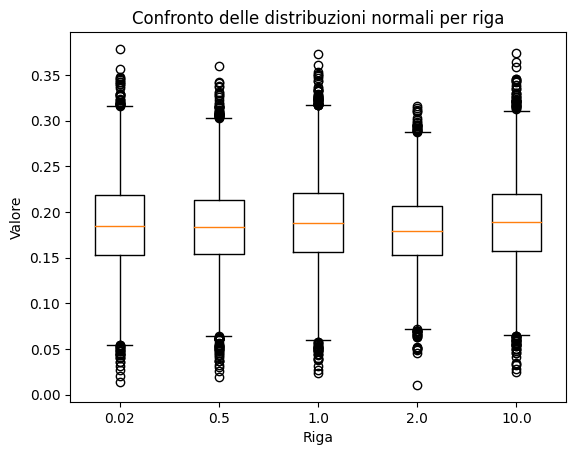

In [54]:
df=pd.read_csv('/content/drive/MyDrive/thesis/data/varying_alpha_results.csv')

# Numero di campioni da generare per ciascuna riga
num_samples = 10000

# Creazione di un array vuoto per memorizzare tutti i campioni generati
samples = []

# Generazione dei campioni per ciascuna riga
for index, row in df.iterrows():
    mean = row['Mean_KS']
    sd = row['Std_KS']
    sample = np.random.normal(loc=mean, scale=sd, size=num_samples)
    samples.append(sample)

# Creazione del boxplot
plt.boxplot(samples, labels=df.Alpha)
plt.xlabel('Riga')
plt.ylabel('Valore')
plt.title('Confronto delle distribuzioni normali per riga')
plt.show()

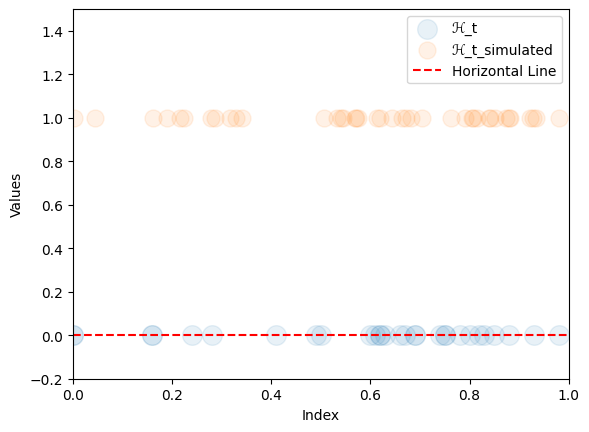

In [ ]:
x = [0]*len(ℋ_t)
# Plot the scatter plot with colors
plt.scatter(ℋ_t, x, label='ℋ_t', alpha=0.1,s=200)

x = [1]*len(ℋ_t_simulated)
# Plot the scatter plot with colors
plt.scatter(ℋ_t_simulated, x, label='ℋ_t_simulated', alpha=0.1,s=150)

# Plot the horizontal line
plt.axhline(0, color='r', linestyle='--', label='Horizontal Line')

# Add labels and legend
plt.xlabel('Index')
plt.ylabel('Values')
plt.xlim(0,1)
plt.ylim(-0.2,1.5)
plt.legend()

# Show plot
plt.show()

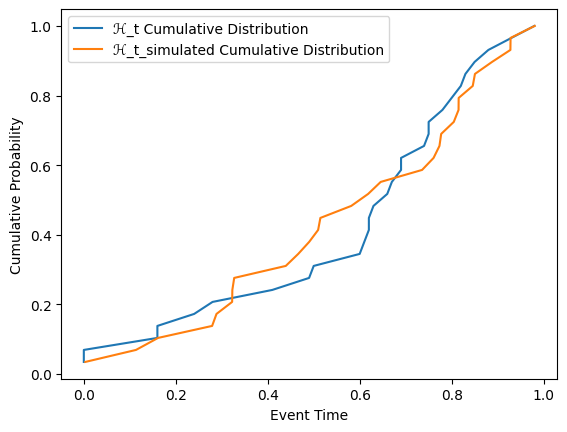

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming ℋ_t and ℋ_t_simulated are arrays of event times

# Calculate cumulative distributions
cumulative_dist_ℋ_t = np.arange(1, len(ℋ_t) + 1) / len(ℋ_t)
cumulative_dist_ℋ_t_simulated = np.arange(1, len(ℋ_t_simulated) + 1) / len(ℋ_t_simulated)

# Plot the cumulative distributions
plt.plot(np.sort(ℋ_t), cumulative_dist_ℋ_t, label='ℋ_t Cumulative Distribution')
plt.plot(np.sort(ℋ_t_simulated), cumulative_dist_ℋ_t_simulated, label='ℋ_t_simulated Cumulative Distribution')

# Add labels and legend
plt.xlabel('Event Time')
plt.ylabel('Cumulative Probability')
plt.legend()

# Show plot
plt.show()


In [ ]:
from scipy.stats import ks_2samp

# Calculate KS statistic and p-value
ks_statistic, p_value = ks_2samp(cumulative_dist_ℋ_t, cumulative_dist_ℋ_t_simulated)

print("KS Statistic:", ks_statistic)
print("p-value:", p_value)


KS Statistic: 0.038620689655172416
p-value: 0.999999999999999


# Test with Metrics

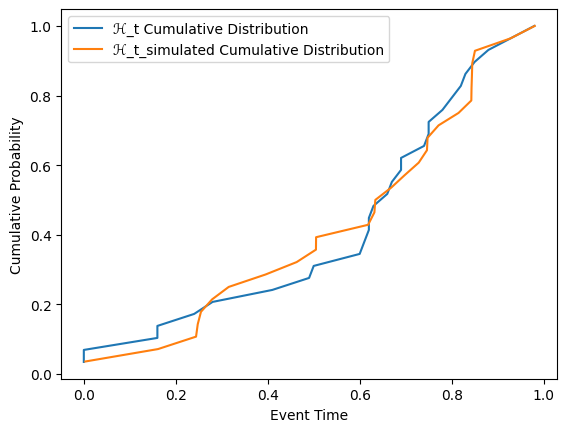

KS Statistic: 0.034482758620689655
p-value: 1.0


In [ ]:
grouped_counts = root.groupby('user')['comment_id'].count()

# Seleziona solo i valori maggiori di due
selected_users = grouped_counts[grouped_counts > 5].reset_index().user


root['time']=ℋ_t.round(2)
root=root[root['user'].isin(selected_users)]
grouped_counts = root.groupby('time').agg({'user': 'nunique', 'comment_id': 'nunique'}).reset_index()
grouped_counts['Activity']=grouped_counts['comment_id']/grouped_counts['user']

len(root.user.unique())
len(simulated_thread_df.user.unique())


simulated_thread_df['time']=simulated_thread_df.timestamp.round(2)
simulated_thread_df=simulated_thread_df[simulated_thread_df['user'].isin(selected_users)]
grouped_counts_estimated = simulated_thread_df.groupby('time').agg(unique_users=('user', 'nunique'), total_users=('user', 'count')).reset_index()
grouped_counts_estimated['Activity']=grouped_counts_estimated['total_users']/grouped_counts_estimated['unique_users']



merged_data = pd.merge(grouped_counts_estimated, grouped_counts, on='time', suffixes=('_estimated', '_actual'))
'''
import matplotlib.pyplot as plt

# Plot dei punti 'y' (Activity_actual)
plt.scatter(merged_data['time'], merged_data['Activity_actual'], label='Activity_actual', alpha=0.5)

# Plot dei punti 'y_hat' (Activity_estimated)
plt.scatter(merged_data['time'], merged_data['Activity_estimated'], label='Activity_estimated', alpha=0.5)

# Colleghi i punti 'y' con una linea
plt.plot(merged_data['time'], merged_data['Activity_actual'], linestyle='-', color='blue')

# Colleghi i punti 'y_hat' con una linea
plt.plot(merged_data['time'], merged_data['Activity_estimated'], linestyle='-', color='orange')

# Aggiungi etichette agli assi
plt.xlabel('Time')
plt.ylabel('Activity')

# Aggiungi una legenda
plt.legend()

# Mostra il plot
plt.show()
'''


import numpy as np
import matplotlib.pyplot as plt

# Assuming ℋ_t and ℋ_t_simulated are arrays of event times

# Calculate cumulative distributions

ℋ_t_simulated=simulated_thread_df['timestamp']
ℋ_t=root['time']
cumulative_dist_ℋ_t = np.arange(1, len(ℋ_t) + 1) / len(ℋ_t)
cumulative_dist_ℋ_t_simulated = np.arange(1, len(ℋ_t_simulated) + 1) / len(ℋ_t_simulated)

# Plot the cumulative distributions
plt.plot(np.sort(ℋ_t), cumulative_dist_ℋ_t, label='ℋ_t Cumulative Distribution')
plt.plot(np.sort(ℋ_t_simulated), cumulative_dist_ℋ_t_simulated, label='ℋ_t_simulated Cumulative Distribution')

# Add labels and legend
plt.xlabel('Event Time')
plt.ylabel('Cumulative Probability')
plt.legend()

# Show plot
plt.show()



from scipy.stats import ks_2samp
# NON FUNZION APORCODDIOOO
# Assuming cumulative_dist_ℋ_t and cumulative_dist_ℋ_t_simulated are arrays of cumulative distributions

# Calculate KS statistic and p-value
ks_statistic, p_value = ks_2samp(cumulative_dist_ℋ_t, cumulative_dist_ℋ_t_simulated)

print("KS Statistic:", ks_statistic)
print("p-value:", p_value)


# Identify best value of Beta

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp
grid_search_results=pd.read_csv('/content/drive/MyDrive/thesis/data/grid_search_results.csv')
def simulate_behaviour(alpha,beta,root_id):
  start_time = time.time()
  parameter_pool=grid_search_results

  parameter_pool=parameter_pool[(parameter_pool['beta']==beta) & (parameter_pool['alpha']<alpha) ].copy()
  root=dataset[dataset['root_submission']==root_id]
  root = root.sort_values(by='created_at')
  observed_data = np.array([np.datetime64(x.replace(tzinfo=None)).astype(np.int64) for x in root['created_at']])
  start_conversation=np.datetime64(min(root['created_at']).replace(tzinfo=None))
  end_conversation=np.datetime64(max(root['created_at']).replace(tzinfo=None))

  ℋ_t=root['time'] = (np.array([np.datetime64(x.replace(tzinfo=None)).astype(np.int64) for x in root['created_at']]) - start_conversation.astype(np.int64)) / (end_conversation.astype(np.int64) - start_conversation.astype(np.int64)).copy()

  first_comments_table = root.groupby('user')['created_at'].first().reset_index()
  first_comments = np.array([np.datetime64(x.replace(tzinfo=None)).astype(np.int64) for x in first_comments_table['created_at']])
  oss_staring_conversation = (first_comments - start_conversation.astype(np.int64)) / (end_conversation.astype(np.int64) - start_conversation.astype(np.int64))
  first_comments_table['created_at']=oss_staring_conversation

  last_comments_table = root.groupby('user')['created_at'].last().reset_index()
  last_comments = np.array([np.datetime64(x.replace(tzinfo=None)).astype(np.int64) for x in last_comments_table['created_at']])
  oss_finishing_conversation = (last_comments - start_conversation.astype(np.int64)) / (end_conversation.astype(np.int64) - start_conversation.astype(np.int64))
  last_comments_table['created_at']=oss_finishing_conversation

  user_activity=root['user'].value_counts().reset_index()

  simulated_thread_df = pd.DataFrame(columns=['user', 'timestamp'])  # Creiamo il DataFrame vuoto


  for index, row in (user_activity.iterrows()):
    user_name = row['user']
    number_of_comments = row['count']
    t_init=first_comments_table[first_comments_table['user']==user_name]['created_at'].iloc[0]
    t_final=last_comments_table[last_comments_table['user']==user_name]['created_at'].iloc[0]

    if number_of_comments==1:
      user_df = pd.DataFrame({'user': [user_name], 'timestamp': [t_init]})
      simulated_thread_df = pd.concat([simulated_thread_df, user_df], ignore_index=True)
    else:
      if sum(parameter_pool['mu_expected_value'].round() == number_of_comments-2)==0:
        parameters_cool = parameter_pool.query(f"({number_of_comments - 20} <= mu_expected_value.round() <= {number_of_comments + 20})")
        parameters_cool = parameters_cool.loc[parameters_cool['alpha'].idxmax()]
      else:
        parameters_cool = parameter_pool[parameter_pool['mu_expected_value'].round() == number_of_comments-2]
        parameters_cool = parameters_cool.loc[parameters_cool['alpha'].idxmax()]
      theta = np.array(parameters_cool[['lambda', 'alpha', 'beta']])

      simulated_timestamp = exp_simulate_by_composition_alt(theta, 1)
      simulated_timestamp=(simulated_timestamp*(t_final-t_init))+t_init
      simulated_timestamp= np.concatenate(([t_init], simulated_timestamp,[t_final]))
      user_df = pd.DataFrame({'user': [user_name] * (len(simulated_timestamp)), 'timestamp': simulated_timestamp})
      simulated_thread_df = pd.concat([simulated_thread_df, user_df], ignore_index=True)

  simulated_thread_df.sort_values(by='timestamp', inplace=True)
  ℋ_t_simulated=simulated_thread_df['timestamp']

  # Test with metrics


  grouped_counts = root.groupby('user')['comment_id'].count()

  # Seleziona solo i valori maggiori di due
  selected_users = grouped_counts[grouped_counts > 10].reset_index().user
  if len(selected_users)>0:
    root.loc[:, 'time'] = root.time.round(2)
    root=root[root['user'].isin(selected_users)]
    grouped_counts = root.groupby('time').agg({'user': 'nunique', 'comment_id': 'nunique'}).reset_index()
    grouped_counts['Activity']=grouped_counts['comment_id']/grouped_counts['user']

    simulated_thread_df['time']=simulated_thread_df.timestamp.round(2)
    simulated_thread_df=simulated_thread_df[simulated_thread_df['user'].isin(selected_users)]
    grouped_counts_estimated = simulated_thread_df.groupby('time').agg(unique_users=('user', 'nunique'), total_users=('user', 'count')).reset_index()
    grouped_counts_estimated['Activity']=grouped_counts_estimated['total_users']/grouped_counts_estimated['unique_users']

    merged_data = pd.merge(grouped_counts_estimated, grouped_counts, on='time', suffixes=('_estimated', '_actual'))

    ℋ_t_simulated=simulated_thread_df['timestamp']
    ℋ_t=root['time']
    cumulative_dist_ℋ_t = np.arange(1, len(ℋ_t) + 1) / len(ℋ_t)
    cumulative_dist_ℋ_t_simulated = np.arange(1, len(ℋ_t_simulated) + 1) / len(ℋ_t_simulated)

    ks_statistic, p_value = ks_2samp(cumulative_dist_ℋ_t, cumulative_dist_ℋ_t_simulated)

    return ks_statistic
  else:
    return 100

In [ ]:
import numpy as np
from scipy.stats import ks_2samp
from tqdm import tqdm

def compare_distributions(root_id, beta, alpha):
    ks_results_no_ex = []
    ks_results_ex = []

    # Simulate for beta
    for i in (range(50)):
        ks = simulate_behaviour(alpha, beta, root_id)
        ks_results_ex.append(ks)
        ks = simulate_behaviour(0.5, beta, root_id)
        ks_results_no_ex.append(ks)


    # Calculate KS statistic and p-value
    ks_statistic, p_value = ks_2samp(ks_results_ex, ks_results_no_ex)

    if np.mean(ks_results_ex)<np.mean(ks_results_no_ex):
      return True, p_value
    else:
      return False, p_value


comment_counts = dataset.groupby('root_submission').size().reset_index(name='comment_count')
root_submission_50 = comment_counts[comment_counts['comment_count'] >= 50]


import pandas as pd
from tqdm import tqdm

# Create an empty DataFrame to store the results
root_ids = []
results=[]
signficances=[]
alpha=20
beta=80

# Loop over each root_submission that appears at least 50 times
for root_id in tqdm(root_submission_50['root_submission'].unique()[1:500], desc="Processing root submissions"):
    # Perform comparison and get KS statistic and p-value
    ks_statistic, p_value = compare_distributions(root_id, beta, alpha)
    root_ids.append(root_id)
    results.append(ks_statistic)
    signficances.append(p_value)
    # Append results to the DataFrame
    results_df = {'root_ids': root_ids, 'results': results, 'signficances': signficances,'beta':beta,'alpha':alpha }
    results_df = pd.DataFrame(results_df)

    results_df.to_csv('/content/drive/MyDrive/thesis/data/is_improving_ex_on_roots.csv')

Processing root submissions:  13%|█▎        | 65/499 [59:25<6:22:35, 52.89s/it]

In [ ]:
grid_search_results[(grid_search_results['beta']==80) & (grid_search_results['alpha']<20)]
dataset[dataset['root_submission']=='1000833'].user.value_counts()

,lambda,alpha,beta,mu_expected_value,sd_exepected_value
2,0.01,0.01,80,0.010,0.083373
16,0.01,10.00,80,0.147,0.389661
86,1.00,0.01,80,1.048,0.992774
100,1.00,10.00,80,1.278,1.246046
170,2.00,0.01,80,2.028,1.323958
...,...,...,...,...,...
24964,297.00,10.00,80,339.014,21.254688
25034,298.00,0.01,80,297.904,17.770271
25048,298.00,10.00,80,339.899,20.506365
25118,299.00,0.01,80,299.027,16.876671
